# Banking research analysis 2

Research questions:
 - is the transmission of ECB conventional monetary policy effective on banks’ volumes and banks’ rates since 2014?
 - is there a time lag?

## Importing dependecies

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import statsmodels.api as sm
from matplotlib import style

In [4]:
# Setting style for every plot
plt.style.use('ggplot')

# or 'seaborn' style

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_89324/3415471106.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## Data preparation

The data was gathered from the Statistical Data Warehouse webite affiliated with the ECB. After some considerations we decided to extract data relative to:
- MRO
- Cost of borrowings (< and > 1 year maturity)
- Loan rates outstandings
- business volumes of loans
- bank's lending margins over euro area countries

After some excel modifications and merging the datasets, we ended up with two cleaned datasets: one with the first 4 parts from above (110 rows x 15 columns), and one with the lending margins (110 rows x 20 columns).

Both datasets are indexed through date: we gathered monthly data from January 2014 up until March 2023.

In [5]:
df = pd.read_excel('datasets/MRO.xls')

In [6]:
df.drop(0, 0, inplace=True)

/var/folders/y1/w89cf9v14zb9dn4l_yrgzfth0000gn/T/ipykernel_89324/2701482825.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(0, 0, inplace=True)


In [7]:
df = df.iloc[::-1,].reset_index(drop=True)
df.rename(columns={'Value' : 'MRO'}, inplace=True)
df

,Date,MRO
0,2014-01-01,0.25
1,2014-02-01,0.25
2,2014-03-01,0.25
3,2014-04-01,0.25
4,2014-05-01,0.25
...,...,...
105,2022-10-01,2.00
106,2022-11-01,2.00
107,2022-12-01,2.50
108,2023-01-01,3.00


In [8]:
df_rates = pd.read_excel('datasets/LoansRates_outstandings.xls', sheet_name='Sheet1')
df_rates = df_rates.iloc[::-1,].reset_index(drop=True)
# df_rates

In [9]:
df_cob = pd.read_excel('datasets/cob_movingaverage.xls', sheet_name='Sheet1')
df_cob = df_cob.iloc[::-1,].reset_index(drop=True)
# df_cob

In [10]:
df_volumes = pd.read_excel('datasets/business_volumes.xls', sheet_name= 'Sheet1')
df_volumes = df_volumes.iloc[::-1,].reset_index(drop=True)
# df_volumes

In [11]:
data = pd.concat([df, df_cob.iloc[:, 1:], df_rates.iloc[:, 1:], df_volumes.iloc[:, 1:]], axis=1)
data.head()
# data for volumes in million of euros
# MRO, Cob, and rates are all in percentages

,Date,MRO,"Cob, up to 1 year","Cob, over 1 year","Rates to corporations, up to 1 year","Rates to corporations, over 1 year","Rates for house purchases, up to 1 year","Rates for house purchases, over 1 year","Rates for consumptions and others, up to 1 year","Rates for consumptions, over 1 year","Loans to Corporations, up to 1 year","Loans to corporations, over 1 year","Lending for house purchases, up to 1 year","Lending for house purchases, over 1 year","Loans for households consumptions, up to 1 year","Loans for households consumptions, over 1 year"
0,2014-01-01,0.25,2.95,3.22,3.69,3.17,3.31,3.29,7.62,5.01,177949.29,19438.21,12198.65,29437.53,2688.41,12021.54
1,2014-02-01,0.25,2.95,3.18,3.66,3.21,3.30,3.35,7.67,5.09,148452.00,17323.36,11580.23,27872.59,2377.54,12072.53
2,2014-03-01,0.25,2.97,3.16,3.64,3.18,3.30,3.32,7.64,5.01,170872.68,19085.67,12564.71,29067.69,2650.09,13465.63
3,2014-04-01,0.25,2.96,3.13,3.65,3.18,3.37,3.30,7.55,5.03,179919.58,19175.85,12458.21,31706.92,2557.98,14040.44
4,2014-05-01,0.25,2.90,3.06,3.60,3.17,3.33,3.28,7.54,5.01,154976.81,17085.80,12170.53,29756.39,2423.85,13575.69


In [12]:
data['Date'] = data['Date'].apply(pd.to_datetime)
data.set_index('Date',inplace=True)
data.head()

,MRO,"Cob, up to 1 year","Cob, over 1 year","Rates to corporations, up to 1 year","Rates to corporations, over 1 year","Rates for house purchases, up to 1 year","Rates for house purchases, over 1 year","Rates for consumptions and others, up to 1 year","Rates for consumptions, over 1 year","Loans to Corporations, up to 1 year","Loans to corporations, over 1 year","Lending for house purchases, up to 1 year","Lending for house purchases, over 1 year","Loans for households consumptions, up to 1 year","Loans for households consumptions, over 1 year"
Date,,,,,,,,,,,,,,,
2014-01-01,0.25,2.95,3.22,3.69,3.17,3.31,3.29,7.62,5.01,177949.29,19438.21,12198.65,29437.53,2688.41,12021.54
2014-02-01,0.25,2.95,3.18,3.66,3.21,3.30,3.35,7.67,5.09,148452.00,17323.36,11580.23,27872.59,2377.54,12072.53
2014-03-01,0.25,2.97,3.16,3.64,3.18,3.30,3.32,7.64,5.01,170872.68,19085.67,12564.71,29067.69,2650.09,13465.63
2014-04-01,0.25,2.96,3.13,3.65,3.18,3.37,3.30,7.55,5.03,179919.58,19175.85,12458.21,31706.92,2557.98,14040.44
2014-05-01,0.25,2.90,3.06,3.60,3.17,3.33,3.28,7.54,5.01,154976.81,17085.80,12170.53,29756.39,2423.85,13575.69


In [13]:
margins = pd.read_excel('datasets/banks_lending_margins.xls', sheet_name='Sheet1')
margins = margins.iloc[::-1,].reset_index(drop=True)

margins['Date'] = margins['Date'].apply(pd.to_datetime)
margins.set_index('Date',inplace=True)
margins.head()

,Austria,Belgium,Cyprus,Germany,Estonia,Spain,Finland,France,Greece,Ireland,Italy,Lithuania,Luxembourg,Latvia,Malta,Netherlands,Portugal,Slovenia,Slovakia,EU_average
Date,,,,,,,,,,,,,,,,,,,,
2014-01-01,1.3609,1.4896,3.3124,1.8328,2.2141,2.3167,1.2122,1.4653,2.6470,2.5885,1.6463,2.4456,1.4014,3.4374,1.6537,2.3175,3.5345,2.6039,2.2076,2.194074
2014-02-01,1.3404,1.5041,2.7681,1.8280,2.5632,2.4728,1.3086,1.4944,2.3820,2.8328,1.6513,2.3696,1.4727,3.7921,2.2154,2.3583,3.3568,3.1184,1.9953,2.253911
2014-03-01,1.3017,1.5139,2.8993,1.9497,2.6848,2.5406,1.4667,1.4645,2.4275,2.9685,1.6675,2.1816,1.4459,3.2930,2.5365,2.4864,3.8627,3.1681,2.0317,2.310032
2014-04-01,1.2752,1.5406,2.8666,1.8342,2.7590,2.6922,1.2043,1.4104,3.7878,2.8713,1.7406,2.4896,1.4042,3.9488,1.8695,2.3292,3.7964,3.4996,2.1213,2.391621
2014-05-01,1.3140,1.5722,2.8086,1.8328,2.3384,2.6095,1.1124,1.4790,2.8461,2.8505,1.5861,2.3504,1.3984,2.5767,2.3807,2.2962,3.8959,3.3832,1.9983,2.243653


Text(0, 0.5, '%')

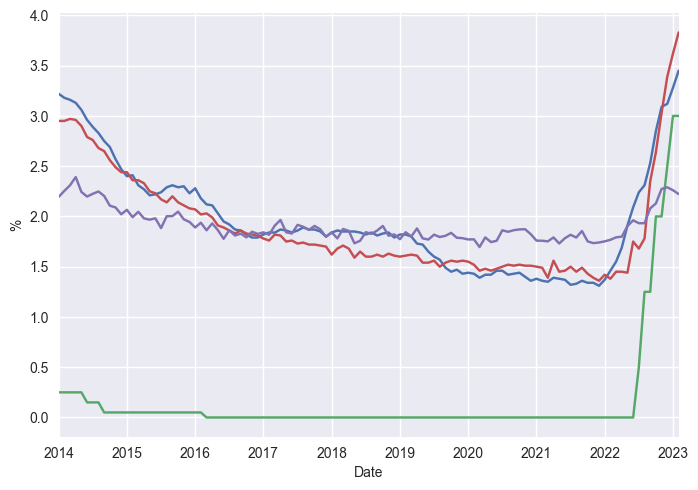

In [14]:
data['Cob, over 1 year'].plot()
data['MRO'].plot()
data[ 'Cob, up to 1 year'].plot()
margins['EU_average'].plot()
plt.ylabel('%')

Text(0, 0.5, '%')

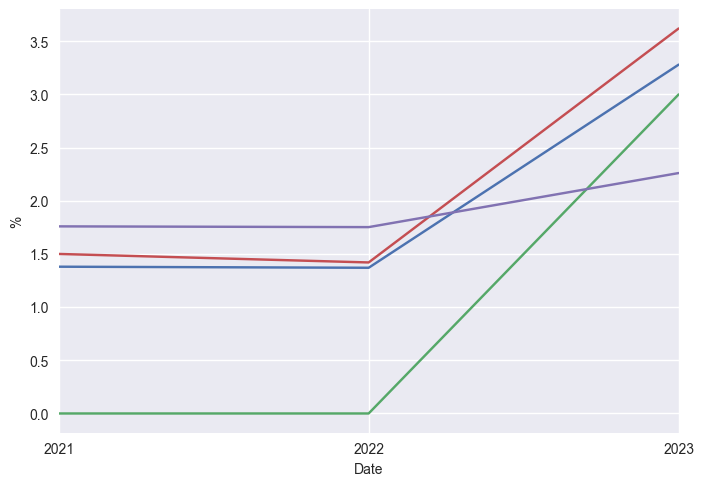

In [15]:
data.loc[[ '2021','2022', '2023'],'Cob, over 1 year'].plot()
data.loc[[ '2021','2022', '2023'],'MRO'].plot()
data.loc[[ '2021','2022', '2023'], 'Cob, up to 1 year'].plot()
margins.loc[[ '2021','2022', '2023'],'EU_average'].plot()
plt.ylabel('%')

In [16]:
data.loc['2020', 'MRO']

Date
2020-01-01    0.0
2020-02-01    0.0
2020-03-01    0.0
2020-04-01    0.0
2020-05-01    0.0
2020-06-01    0.0
2020-07-01    0.0
2020-08-01    0.0
2020-09-01    0.0
2020-10-01    0.0
2020-11-01    0.0
2020-12-01    0.0
Name: MRO, dtype: float64

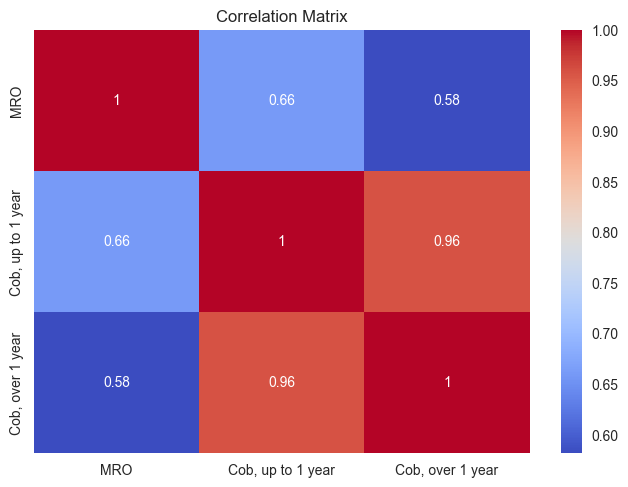

In [17]:
corr_matrix = data.iloc[:,:3].corr()
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

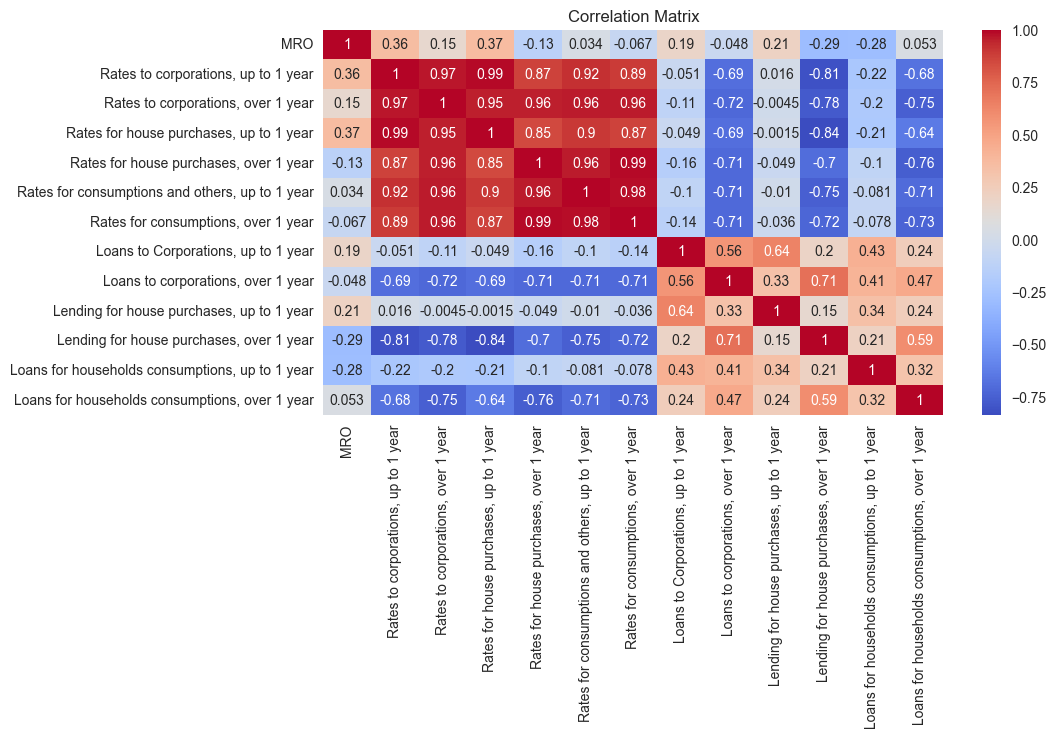

In [18]:
plt.figure(figsize= (10, 5))
corr_matrix = data.iloc[:, [0, 3,4,5,6,7,8, 9, 10, 11, 12, 13, 14]].corr()
sn.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [19]:
# regression test COB over 1 year
Y = data['Cob, over 1 year'] # storing dependent variable
X = data['MRO'] # storing explanatory variables
X = sm.add_constant(X)        # to add constant value in the model
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Cob, over 1 year   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.332
Method:                 Least Squares   F-statistic:                     55.19
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           2.70e-11
Time:                        10:56:36   Log-Likelihood:                -64.996
No. Observations:                 110   AIC:                             134.0
Df Residuals:                     108   BIC:                             139.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8711      0.044     42.629      0.000       1.784       1.958
MRO            0.5696      0.077      7.429      0.000       0.418       0.722
==============================================================================
Omnibus:                       16.278   Durbin-Watson:                   0.031
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.565
Skew:                           0.975   Prob(JB):                     9.31e-05
Kurtosis:                       3.498   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
# regression test COB up to 1 year
Y = data['Cob, up to 1 year'] # storing dependent variable
X = data['MRO'] # storing explanatory variables
X = sm.add_constant(X)        # to add constant value in the model
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      Cob, up to 1 year   R-squared:                       0.437
Model:                            OLS   Adj. R-squared:                  0.432
Method:                 Least Squares   F-statistic:                     83.97
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           3.71e-15
Time:                        10:56:36   Log-Likelihood:                -52.615
No. Observations:                 110   AIC:                             109.2
Df Residuals:                     108   BIC:                             114.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.7959      0.039     45.790      0.000       1.718       1.874
MRO            0.6278      0.069      9.163      0.000       0.492       0.764
==============================================================================
Omnibus:                       19.813   Durbin-Watson:                   0.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.215
Skew:                           1.120   Prob(JB):                     5.52e-06
Kurtosis:                       3.514   Cond. No.                         1.89
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""